
# Multi-compartment neuron example

Simple example of how to use the three-compartment ``iaf_cond_alpha_mc``
neuron model.

Three stimulation paradigms are illustrated:

 - externally applied current, one compartment at a time
 - spikes impinging on each compartment, one at a time
 - rheobase current injected to soma causing output spikes

Voltage and synaptic conductance traces are shown for all compartments.


First, we import all necessary modules to simulate, analyze and plot this
example.



In [2]:
import nest
import matplotlib.pyplot as plt

nest.ResetKernel()

We then extract the receptor types and the list of recordable quantities
from the neuron model. Receptor types and recordable quantities uniquely
define the receptor type and the compartment while establishing synaptic
connections or assigning multimeters.



In [3]:
syns = nest.GetDefaults("iaf_cond_alpha_mc")["receptor_types"]
print(f"iaf_cond_alpha_mc receptor_types: {syns}")

rqs = nest.GetDefaults("iaf_cond_alpha_mc")["recordables"]
print(f"iaf_cond_alpha_mc recordables   : {rqs}")

iaf_cond_alpha_mc receptor_types: {'distal_curr': 9, 'distal_exc': 5, 'distal_inh': 6, 'proximal_curr': 8, 'proximal_exc': 3, 'proximal_inh': 4, 'soma_curr': 7, 'soma_exc': 1, 'soma_inh': 2}
iaf_cond_alpha_mc recordables   : ('t_ref_remaining', 'V_m.s', 'g_ex.s', 'g_in.s', 'V_m.p', 'g_ex.p', 'g_in.p', 'V_m.d', 'g_ex.d', 'g_in.d')


The simulation parameters are assigned to variables.



In [4]:
params = {
    "V_th": -60.0,  # threshold potential
    "V_reset": -65.0,  # reset potential
    "t_ref": 10.0,  # refractory period
    "g_sp": 5.0,  # somato-proximal coupling conductance
    "soma": {"g_L": 12.0},  # somatic leak conductance
    # proximal excitatory and inhibitory synaptic time constants
    "proximal": {"tau_syn_ex": 1.0, "tau_syn_in": 5.0},
    "distal": {"C_m": 90.0},  # distal capacitance
}

The nodes are created using ``Create``. We store the returned handles
in variables for later reference.



In [5]:
n = nest.Create("iaf_cond_alpha_mc", params=params)

A ``multimeter`` is created and connected to the neurons. The parameters
specified for the multimeter include the list of quantities that should be
recorded and the time interval at which quantities are measured.



In [6]:
mm = nest.Create("multimeter", params={"record_from": rqs, "interval": 0.1})
nest.Connect(mm, n)

We create one current generator per compartment and configure a stimulus
regime that drives distal, proximal and soma dendrites, in that order.
Configuration of the current generator includes the definition of the start
and stop times and the amplitude of the injected current.



In [7]:
cgs = nest.Create("dc_generator", 3)
cgs[0].set(start=250.0, stop=300.0, amplitude=50.0)  # soma
cgs[1].set(start=150.0, stop=200.0, amplitude=-50.0)  # proxim.
cgs[2].set(start=50.0, stop=100.0, amplitude=100.0)  # distal

Generators are then connected to the correct compartments. Specification of
the ``receptor_type`` uniquely defines the target compartment and receptor.



In [8]:
nest.Connect(cgs[0], n, syn_spec={"receptor_type": syns["soma_curr"]})
nest.Connect(cgs[1], n, syn_spec={"receptor_type": syns["proximal_curr"]})
nest.Connect(cgs[2], n, syn_spec={"receptor_type": syns["distal_curr"]})

We create one excitatory and one inhibitory spike generator per compartment
and configure a regime that drives distal, proximal and soma dendrites, in
that order, alternating the excitatory and inhibitory spike generators.



In [9]:
sgs = nest.Create("spike_generator", 6)
sgs[0].spike_times = [600.0, 620.0]  # soma excitatory
sgs[1].spike_times = [610.0, 630.0]  # soma inhibitory
sgs[2].spike_times = [500.0, 520.0]  # proximal excitatory
sgs[3].spike_times = [510.0, 530.0]  # proximal inhibitory
sgs[4].spike_times = [400.0, 420.0]  # distal excitatory
sgs[5].spike_times = [410.0, 430.0]  # distal inhibitory

Connect generators to correct compartments in the same way as in case of
current generator



In [10]:
nest.Connect(sgs[0], n, syn_spec={"receptor_type": syns["soma_exc"]})
nest.Connect(sgs[1], n, syn_spec={"receptor_type": syns["soma_inh"]})
nest.Connect(sgs[2], n, syn_spec={"receptor_type": syns["proximal_exc"]})
nest.Connect(sgs[3], n, syn_spec={"receptor_type": syns["proximal_inh"]})
nest.Connect(sgs[4], n, syn_spec={"receptor_type": syns["distal_exc"]})
nest.Connect(sgs[5], n, syn_spec={"receptor_type": syns["distal_inh"]})

Run the simulation for 700 ms.



In [11]:
nest.Simulate(700)


May 18 20:15:46 NodeManager::prepare_nodes [Info]: 
    Preparing 11 nodes for simulation.

May 18 20:15:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11
    Simulation time (ms): 700
    Number of OpenMP threads: 1
    Not using MPI

May 18 20:15:46 SimulationManager::run [Info]: 
    Simulation finished.


Now we set the intrinsic current of soma to 150 pA to make the neuron spike.



In [12]:
n.soma = {"I_e": 150.0}

We simulate the network for another 300 ms and retrieve recorded data from
the multimeter



In [13]:
nest.Simulate(300)
rec = mm.events


May 18 20:15:46 NodeManager::prepare_nodes [Info]: 
    Preparing 11 nodes for simulation.

May 18 20:15:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

May 18 20:15:46 SimulationManager::run [Info]: 
    Simulation finished.


We create an array with the time points when the quantities were actually
recorded



In [14]:
t = rec["times"]

We plot the time traces of the membrane potential and the state of each
membrane potential for soma, proximal, and distal dendrites (`V_m.s`, `V_m.p`
and `V_m.d`).



Text(0.5, 1.0, 'Responses of iaf_cond_alpha_mc neuron')

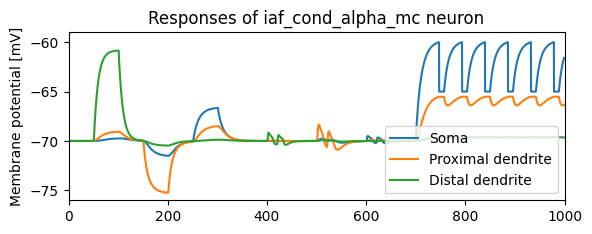

In [15]:
plt.figure()
plt.subplot(211)
plt.plot(t, rec["V_m.s"], t, rec["V_m.p"], t, rec["V_m.d"])
plt.legend(("Soma", "Proximal dendrite", "Distal dendrite"), loc="lower right")
plt.axis([0, 1000, -76, -59])
plt.ylabel("Membrane potential [mV]")
plt.title("Responses of iaf_cond_alpha_mc neuron")

Finally, we plot the time traces of the synaptic conductance measured in
each compartment.



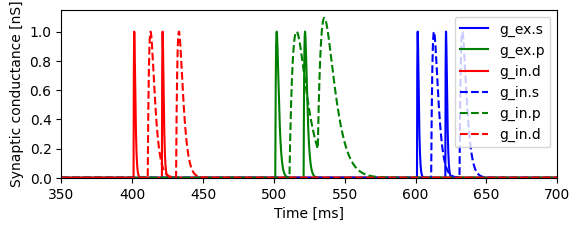

In [16]:
plt.subplot(212)
plt.plot(t, rec["g_ex.s"], "b-", t, rec["g_ex.p"], "g-", t, rec["g_ex.d"], "r-")
plt.plot(t, rec["g_in.s"], "b--", t, rec["g_in.p"], "g--", t, rec["g_in.d"], "r--")
plt.legend(("g_ex.s", "g_ex.p", "g_in.d", "g_in.s", "g_in.p", "g_in.d"))
plt.axis([350, 700, 0, 1.15])
plt.xlabel("Time [ms]")
plt.ylabel("Synaptic conductance [nS]")
plt.show()